In [1]:
!pip install langgraph langchain_openai langchain-google-genai langchain langchain_tavily tavily-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.4/152.4 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.5/64.5 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.5/438.5 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.2/44.2 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 63.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.5/216.5 kB 11.9 MB/s eta 0:00:00
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.60
    Uninstalling langchain-core-0.3.60:
      Successfully uninstalled langchain-core-0.3.60
  Attempting uninstall:

In [1]:
import os
from google.colab import userdata

os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')
os.environ['GOOGLE_API_KEY'] = userdata.get('GOOGLE_API_KEY')
os.environ['TAVILY_API_KEY'] = userdata.get('TAVILY_API_KEY')

In [2]:
from typing_extensions import TypedDict, Annotated
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

## Simple Graph

In [7]:
class State(TypedDict):
    message: str

def greeting(state:State):
    message_content = state['message']
    return {"message": f"Hello, {message_content}!"}

def farewell(state:State):
    message_content = state['message']
    return {"message": f"Goodbye, {message_content}!"}

graph_builder = StateGraph(State)
graph_builder.add_node("greeting_node", greeting)
graph_builder.add_node("farewell_node", farewell)

graph_builder.add_edge(START, "greeting_node")
graph_builder.add_edge("greeting_node", "farewell_node")
graph_builder.add_edge("farewell_node", END)

graph = graph_builder.compile()

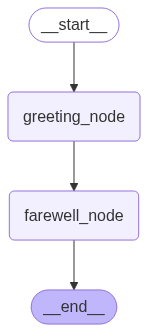

In [8]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [9]:
initial_input = input("Enter your friend's name: ")
graph_state = graph.invoke({"message": initial_input})
graph_state

Enter your friend's name: John


{'message': 'Goodbye, Hello, John!!'}

## Graph with history

In [15]:
import random

class State(TypedDict):
    message: Annotated[list, add_messages]
    count: int

def greeting(state:State):
    message_content = state['message'][0].content
    return {"message": f"Hello, {message_content}!"}

def farewell(state:State):
    message_content = state['message'][0].content
    return {"message": f"Goodbye, {message_content}!"}

def router(state:State):
    if random.random() < 0.5:
        return {"message": "home"}
    else:
        return {"message": "school"}

def go_home_or_school(state:State):
    message_content = state['message'][-1].content
    if message_content == "home":
        return "home_edge"
    else :
        return "school_edge"

def home(state:State):
    message_content = state['message'][0].content
    return {"message": f"Welcome home, {message_content}!"}

def school(state:State):
    message_content = state['message'][0].content
    return {"message": f"Welcome to school, {message_content}!"}

def randon_exercise(state:State):
    return {"message": f"Random exercise: {random.randint(1, 100)}", "count": state['count'] + 1}


def loop_continue(state:State):
    if state['count'] < 5:
        return "continue"
    else:
        return "end"

graph_builder = StateGraph(State)
graph_builder.add_node("greeting_node", greeting)
graph_builder.add_node("farewell_node", farewell)
graph_builder.add_node("router_node", router)
graph_builder.add_node("home", home)
graph_builder.add_node("school", school)
graph_builder.add_node("random_exercise", randon_exercise)

graph_builder.add_edge(START, "greeting_node")
graph_builder.add_edge("greeting_node", "farewell_node")
graph_builder.add_edge("farewell_node", "router_node")
graph_builder.add_conditional_edges(
    "router_node",
    go_home_or_school,
    {
        "home_edge": "home",
        "school_edge": "school"
    })
graph_builder.add_edge("home", END)
graph_builder.add_edge("school", "random_exercise")
graph_builder.add_conditional_edges(
    "random_exercise",
    loop_continue,
    {
    "continue": "random_exercise",
    "end": END
    }
)


graph = graph_builder.compile()

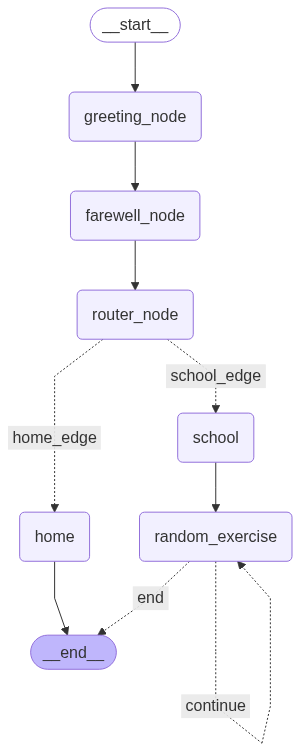

In [16]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [20]:
initial_input = input("Enter your friend's name: ")
graph_state = graph.invoke({"message": initial_input, "count": 0})

Enter your friend's name: test


In [21]:
graph_state

{'message': [HumanMessage(content='test', additional_kwargs={}, response_metadata={}, id='ac69f2b5-4c57-4690-ac79-6f33eba585ab'),
  HumanMessage(content='Hello, test!', additional_kwargs={}, response_metadata={}, id='f92aa7be-13f3-4394-bb87-fef0e313dad6'),
  HumanMessage(content='Goodbye, test!', additional_kwargs={}, response_metadata={}, id='a2408e96-168b-4b73-9c29-7bae95bf4d66'),
  HumanMessage(content='school', additional_kwargs={}, response_metadata={}, id='dacc5469-5f9e-41d2-8b24-23167ddb9da9'),
  HumanMessage(content='Welcome to school, test!', additional_kwargs={}, response_metadata={}, id='2ccaac74-cf1a-4440-bd79-c209ad03efcb'),
  HumanMessage(content='Random exercise: 37', additional_kwargs={}, response_metadata={}, id='343bcfd3-967d-4a81-8e11-be8cd4c5a806'),
  HumanMessage(content='Random exercise: 73', additional_kwargs={}, response_metadata={}, id='c29daf90-4e2c-44f1-a5fd-8b93e81eb6fe'),
  HumanMessage(content='Random exercise: 28', additional_kwargs={}, response_metadata=

In [22]:
for msg in graph_state["message"]:
    print(msg.content)

test
Hello, test!
Goodbye, test!
school
Welcome to school, test!
Random exercise: 37
Random exercise: 73
Random exercise: 28
Random exercise: 66
Random exercise: 94


### Exercise

In [25]:
import random

class State(TypedDict):
    current_value: int
    message: str

def add(state:State):
    added_value = random.randint(1, 10)
    new_current_value = state['current_value'] + added_value
    return {"current_value": new_current_value}

def sub(state:State):
    value = random.randint(1, 10)
    new_current_value = state['current_value'] - value
    return {"current_value": new_current_value}

def mul(state:State):
    value = random.randint(1, 10)
    new_current_value = state['current_value'] * value
    return {"current_value": new_current_value}

def decide_next_step(state:State):
    if random.random() < 0.5:
        return {"message": "sub"}
    else:
        return {"message": "mul"}

graph_builder = StateGraph(State)

graph_builder.add_node("add_node", add)
graph_builder.add_node("subtract_node", sub)
graph_builder.add_node("multiply_node", mul)

graph_builder.add_edge(START, "add_node")
graph_builder.add_conditional_edges(
    "add_node",
    decide_next_step,
    {
        "sub": "subtract_node",
        "mul": "multiply_node",
    }
)
graph_builder.add_edge("subtract_node", END)
graph_builder.add_edge("multiply_node", END)

graph = graph_builder.compile()

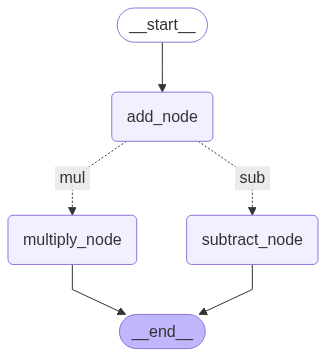

In [26]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

## Chat Bot

In [29]:
from typing import Annotated, Sequence, List
from langchain.chat_models import init_chat_model
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode
from langchain_tavily import TavilySearch

class State(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

@tool
def add_numbers(a: int, b: int) -> int:
    """Add two numbers together."""
    return a + b


tavily_search = TavilySearch(
    max_results=2,
    topic="general",
    api_key=os.environ["TAVILY_API_KEY"],
)


tools = [add_numbers, tavily_search]

graph_builder = StateGraph(State)


llm = init_chat_model("gpt-4.1-nano", model_provider="openai")
llm_with_tools = llm.bind_tools(tools)



def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


def tool_continue(state:State):
    """
    This function checks if the last message is a ToolMessage.
    If it is, it returns "continue" to keep the conversation going.
    Otherwise, it returns "end" to stop the conversation.
    """
    if state["messages"][-1].tool_calls:
        return "continue"
    else:
        return "end"



graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=tools))
graph_builder.add_edge(START, "chatbot")
graph_builder.add_conditional_edges(
    "chatbot",
    tool_continue,
    {
        "continue": "tools",
        "end": END
    }
)
graph_builder.add_edge("tools", "chatbot")  # Loop back to the chatbot node

graph = graph_builder.compile()

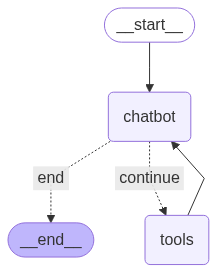

In [30]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [32]:
# response = llm.invoke("What is the weather in new york city now?")
response = llm_with_tools.invoke("What is the weather in new york city now?")
# response = llm_with_tools.invoke("What is result of 5 + 10?")

response

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_QstoKfw7Y56r2Uz13CIzmH5j', 'function': {'arguments': '{"query":"current weather in New York City"}', 'name': 'tavily_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 800, 'total_tokens': 821, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-nano-2025-04-14', 'system_fingerprint': 'fp_38343a2f8f', 'id': 'chatcmpl-BeDr57AmDjU09rax2Ik1Ng8wAy5JN', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--0c86bd48-5f3c-442d-ae5e-b19864efcc0c-0', tool_calls=[{'name': 'tavily_search', 'args': {'query': 'current weather in New York City'}, 'id': 'call_QstoKfw7Y56r2Uz13CIzmH5j', 'type': 'tool_call'}], usage_metadata={'input_tokens': 800, 'output_

In [33]:
user_input = "What is the weather in new york city now?"
graph_state = graph.invoke({"messages": [HumanMessage(user_input)]})

for msg in graph_state["messages"]:
    msg.pretty_print()

================================ Human Message =================================

What is the weather in new york city now?
================================== Ai Message ==================================
Tool Calls:
  tavily_search (call_e5rKAro20ZjctYTqalXU5QzI)
 Call ID: call_e5rKAro20ZjctYTqalXU5QzI
  Args:
    query: current weather in New York City
================================= Tool Message =================================
Name: tavily_search

{"query": "current weather in New York City", "follow_up_questions": null, "answer": null, "images": [], "results": [{"title": "Weather in New York City", "url": "https://www.weatherapi.com/", "content": "{'location': {'name': 'New York', 'region': 'New York', 'country': 'United States of America', 'lat': 40.714, 'lon': -74.006, 'tz_id': 'America/New_York', 'localtime_epoch': 1748926164, 'localtime': '2025-06-03 00:49'}, 'current': {'last_updated_epoch': 1748925900, 'last_updated': '2025-06-03 00:45', 'temp_c': 16.7, 'temp_f': 62.1, 'i